In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving complete_set.csv to complete_set.csv


In [3]:

# Cell 2: Define the Dataset class
class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Cell 3: Load and prepare data
df = pd.read_csv('complete_set.csv')
print(f"Total number of samples: {len(df)}")

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Prepare features and labels
train_texts = train_df['comment'].values
test_texts = test_df['comment'].values
train_labels = train_df.iloc[:, 3:].values  # All columns except Comment
test_labels = test_df.iloc[:, 3:].values

Total number of samples: 35047
Training samples: 28037
Test samples: 7010


In [4]:
# Cell 4: Initialize tokenizer and model
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(df.columns)-3,
    problem_type="multi_label_classification"
)

# Cell 5: Create datasets
train_dataset = CommentDataset(train_texts, train_labels, tokenizer)
test_dataset = CommentDataset(test_texts, test_labels, tokenizer)

# Cell 6: Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Cell 7: Initialize trainer and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

print("Starting training...")
trainer.train()
print("Training completed!")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.299600,0.288678


Training completed!


In [5]:
tag_names = df.columns[3:].tolist()


In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

def evaluate_metrics(predictions, test_labels, tag_names, threshold=0.1):
    """
    Calculate comprehensive classification metrics for all classes and per class.

    Args:
        predictions: Raw model predictions (logits)
        test_labels: True labels
        tag_names: List of class names
        threshold: Probability threshold for positive prediction
    """
    # Convert logits to probabilities and then to binary predictions
    probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()
    preds = (probabilities > threshold).astype(int)

    # Overall accuracy across all samples and classes
    overall_accuracy = accuracy_score(test_labels.flatten(), preds.flatten())

    # Per-class metrics
    class_metrics = []
    for i in range(len(tag_names)):
        # Per-class accuracy
        class_accuracy = accuracy_score(test_labels[:, i], preds[:, i])

        # True positives, false positives, true negatives, false negatives
        tp = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 1))
        fp = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 1))
        tn = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 0))
        fn = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 0))

        # Calculate precision, recall, f1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Support (number of true instances)
        support = np.sum(test_labels[:, i])

        class_metrics.append({
            'class': tag_names[i],
            'accuracy': class_accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': int(support),
            'true_pos': int(tp),
            'false_pos': int(fp),
            'true_neg': int(tn),
            'false_neg': int(fn)
        })

    # Calculate macro averages
    macro_accuracy = np.mean([m['accuracy'] for m in class_metrics])
    macro_precision = np.mean([m['precision'] for m in class_metrics])
    macro_recall = np.mean([m['recall'] for m in class_metrics])
    macro_f1 = np.mean([m['f1'] for m in class_metrics])

    # Print comprehensive report
    print("\nCLASSIFICATION REPORT")
    print("=" * 100)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Macro Accuracy: {macro_accuracy:.4f}")
    print("\nMacro Averages:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1-Score: {macro_f1:.4f}")

    print("\nPer-Class Metrics:")
    print("-" * 100)
    print(f"{'Class':<30} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 100)

    # Sort classes by F1 score for display
    sorted_metrics = sorted(class_metrics, key=lambda x: x['f1'], reverse=True)

    for metric in sorted_metrics:
        print(f"{metric['class'][:30]:<30} "
              f"{metric['accuracy']:>10.4f} "
              f"{metric['precision']:>10.4f} "
              f"{metric['recall']:>10.4f} "
              f"{metric['f1']:>10.4f} "
              f"{metric['support']:>10d}")

    print("\nDetailed Statistics for Top 5 Classes:")
    print("-" * 100)
    for metric in sorted_metrics[:5]:
        print(f"\nClass: {metric['class']}")
        print(f"True Positives: {metric['true_pos']}")
        print(f"False Positives: {metric['false_pos']}")
        print(f"True Negatives: {metric['true_neg']}")
        print(f"False Negatives: {metric['false_neg']}")

    return {
        'overall_accuracy': overall_accuracy,
        'macro_accuracy': macro_accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'class_metrics': class_metrics
    }

def evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.1):
    """
    Evaluate model on test set
    """
    # Create test dataset
    dataset = CommentDataset(test_texts, test_labels, tokenizer)
    predictions = trainer.predict(dataset).predictions

    # Calculate and return metrics
    return evaluate_metrics(predictions, test_labels, tag_names, threshold)

# Example usage
metrics = evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.1)


CLASSIFICATION REPORT
Overall Accuracy: 0.6643
Macro Accuracy: 0.6643

Macro Averages:
Precision: 0.2000
Recall: 0.6579
F1-Score: 0.2938

Per-Class Metrics:
----------------------------------------------------------------------------------------------------
Class                            Accuracy  Precision     Recall   F1-Score    Support
----------------------------------------------------------------------------------------------------
tough_grader                       0.6830     0.4279     0.9135     0.5828       1699
amazing_lectures                   0.6268     0.3007     0.9341     0.4550       1169
caring                             0.5793     0.2988     0.9275     0.4520       1311
get_ready_to_read                  0.4562     0.2737     0.9020     0.4200       1530
respected                          0.5468     0.2620     0.9338     0.4092       1178
gives_good_feedback                0.5683     0.2608     0.9294     0.4074       1119
lecture_heavy                      0.4

In [7]:
# Example Usage
metrics = evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.2)



CLASSIFICATION REPORT
Overall Accuracy: 0.8155
Macro Accuracy: 0.8155

Macro Averages:
Precision: 0.2604
Recall: 0.4201
F1-Score: 0.3038

Per-Class Metrics:
----------------------------------------------------------------------------------------------------
Class                            Accuracy  Precision     Recall   F1-Score    Support
----------------------------------------------------------------------------------------------------
tough_grader                       0.7686     0.5141     0.8270     0.6340       1699
amazing_lectures                   0.7277     0.3589     0.8050     0.4964       1169
caring                             0.6990     0.3602     0.7849     0.4938       1311
get_ready_to_read                  0.6469     0.3541     0.7497     0.4810       1530
gives_good_feedback                0.7157     0.3273     0.7399     0.4538       1119
hilarious                          0.8234     0.3588     0.5819     0.4438        849
respected                          0.6

In [8]:
metrics = evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.3)



CLASSIFICATION REPORT
Overall Accuracy: 0.8711
Macro Accuracy: 0.8711

Macro Averages:
Precision: 0.3147
Recall: 0.2420
F1-Score: 0.2440

Per-Class Metrics:
----------------------------------------------------------------------------------------------------
Class                            Accuracy  Precision     Recall   F1-Score    Support
----------------------------------------------------------------------------------------------------
tough_grader                       0.8003     0.5667     0.7475     0.6447       1699
amazing_lectures                   0.7986     0.4288     0.6262     0.5090       1169
get_ready_to_read                  0.7702     0.4756     0.5170     0.4955       1530
caring                             0.7743     0.4243     0.5789     0.4897       1311
hilarious                          0.8732     0.4733     0.4170     0.4433        849
gives_good_feedback                0.8098     0.4119     0.4468     0.4286       1119
respected                          0.7


CLASSIFICATION REPORT
Overall Accuracy: 0.6643
Macro Accuracy: 0.6643

Macro Averages:
Precision: 0.2000
Recall: 0.6579
F1-Score: 0.2938

Per-Class Metrics:
----------------------------------------------------------------------------------------------------
Class                            Accuracy  Precision     Recall   F1-Score    Support
----------------------------------------------------------------------------------------------------
tough_grader                       0.6830     0.4279     0.9135     0.5828       1699
amazing_lectures                   0.6268     0.3007     0.9341     0.4550       1169
caring                             0.5793     0.2988     0.9275     0.4520       1311
get_ready_to_read                  0.4562     0.2737     0.9020     0.4200       1530
respected                          0.5468     0.2620     0.9338     0.4092       1178
gives_good_feedback                0.5683     0.2608     0.9294     0.4074       1119
lecture_heavy                      0.4

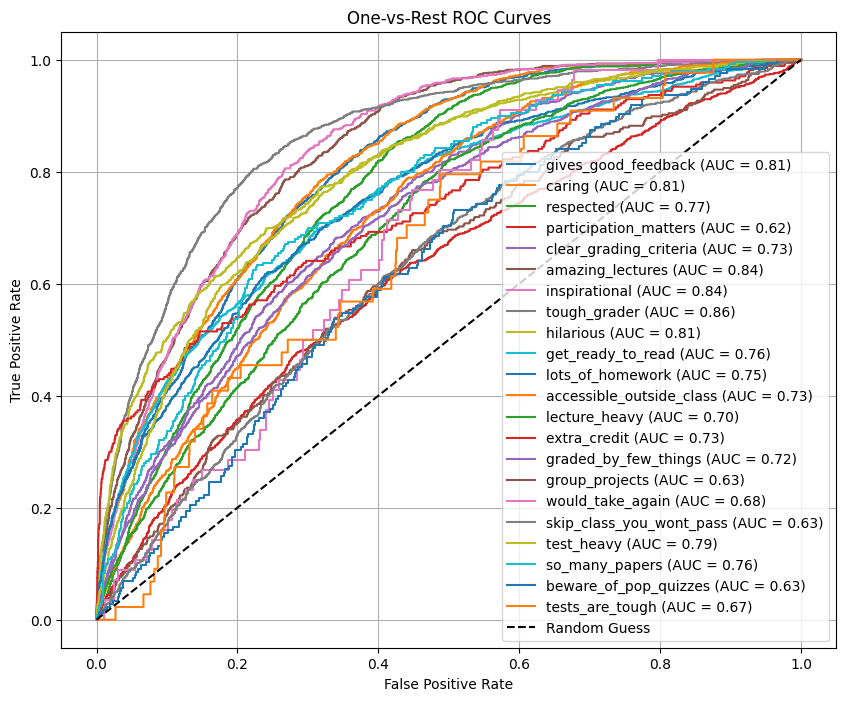

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
import numpy as np
import torch
import matplotlib.pyplot as plt


def evaluate_metrics(predictions, test_labels, tag_names, threshold=0.1):
    """
    Calculate comprehensive classification metrics for all classes and per class.

    Args:
        predictions: Raw model predictions (logits)
        test_labels: True labels
        tag_names: List of class names
        threshold: Probability threshold for positive prediction
    """
    # Convert logits to probabilities and then to binary predictions
    probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()
    preds = (probabilities > threshold).astype(int)

    # Overall accuracy across all samples and classes
    overall_accuracy = accuracy_score(test_labels.flatten(), preds.flatten())

    # Per-class metrics
    class_metrics = []
    for i in range(len(tag_names)):
        # Per-class accuracy
        class_accuracy = accuracy_score(test_labels[:, i], preds[:, i])

        # True positives, false positives, true negatives, false negatives
        tp = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 1))
        fp = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 1))
        tn = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 0))
        fn = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 0))

        # Calculate precision, recall, f1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Support (number of true instances)
        support = np.sum(test_labels[:, i])

        class_metrics.append({
            'class': tag_names[i],
            'accuracy': class_accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': int(support),
            'true_pos': int(tp),
            'false_pos': int(fp),
            'true_neg': int(tn),
            'false_neg': int(fn)
        })

    # Calculate macro averages
    macro_accuracy = np.mean([m['accuracy'] for m in class_metrics])
    macro_precision = np.mean([m['precision'] for m in class_metrics])
    macro_recall = np.mean([m['recall'] for m in class_metrics])
    macro_f1 = np.mean([m['f1'] for m in class_metrics])

    # Print comprehensive report
    print("\nCLASSIFICATION REPORT")
    print("=" * 100)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Macro Accuracy: {macro_accuracy:.4f}")
    print("\nMacro Averages:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1-Score: {macro_f1:.4f}")

    print("\nPer-Class Metrics:")
    print("-" * 100)
    print(f"{'Class':<30} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 100)

    # Sort classes by F1 score for display
    sorted_metrics = sorted(class_metrics, key=lambda x: x['f1'], reverse=True)

    for metric in sorted_metrics:
        print(f"{metric['class'][:30]:<30} "
              f"{metric['accuracy']:>10.4f} "
              f"{metric['precision']:>10.4f} "
              f"{metric['recall']:>10.4f} "
              f"{metric['f1']:>10.4f} "
              f"{metric['support']:>10d}")

    print("\nDetailed Statistics for Top 5 Classes:")
    print("-" * 100)
    for metric in sorted_metrics[:5]:
        print(f"\nClass: {metric['class']}")
        print(f"True Positives: {metric['true_pos']}")
        print(f"False Positives: {metric['false_pos']}")
        print(f"True Negatives: {metric['true_neg']}")
        print(f"False Negatives: {metric['false_neg']}")

    # Plot ROC curves for one-vs-rest evaluation
    plot_roc_curves(test_labels, probabilities, tag_names)

    return {
        'overall_accuracy': overall_accuracy,
        'macro_accuracy': macro_accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'class_metrics': class_metrics
    }


def plot_roc_curves(test_labels, probabilities, tag_names):
    """
    Plot one-vs-rest ROC curves for multi-label classification.

    Args:
        test_labels: True binary labels for each class.
        probabilities: Predicted probabilities for each class.
        tag_names: List of class names.
    """
    plt.figure(figsize=(10, 8))

    for i, tag in enumerate(tag_names):
        # Calculate ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(test_labels[:, i], probabilities[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot each class ROC curve
        plt.plot(fpr, tpr, label=f"{tag} (AUC = {roc_auc:.2f})")

    # Plot a diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

    # Add plot details
    plt.title("One-vs-Rest ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


def evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.1):
    """
    Evaluate model on test set
    """
    # Create test dataset
    dataset = CommentDataset(test_texts, test_labels, tokenizer)
    predictions = trainer.predict(dataset).predictions

    # Calculate and return metrics
    return evaluate_metrics(predictions, test_labels, tag_names, threshold)


# Example usage
metrics = evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.1)


In [10]:
def evaluate_metrics(predictions, test_labels, tag_names, threshold=0.1):
    """
    Calculate comprehensive classification metrics for all classes and per class.

    Args:
        predictions: Raw model predictions (logits)
        test_labels: True labels
        tag_names: List of class names
        threshold: Probability threshold for positive prediction
    """
    # Convert logits to probabilities and then to binary predictions
    probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()
    preds = (probabilities > threshold).astype(int)

    # Overall accuracy across all samples and classes
    overall_accuracy = accuracy_score(test_labels.flatten(), preds.flatten())

    # Per-class metrics
    class_metrics = []
    for i in range(len(tag_names)):
        # Per-class accuracy
        class_accuracy = accuracy_score(test_labels[:, i], preds[:, i])

        # True positives, false positives, true negatives, false negatives
        tp = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 1))
        fp = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 1))
        tn = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 0))
        fn = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 0))

        # Calculate precision, recall, f1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Support (number of true instances)
        support = np.sum(test_labels[:, i])

        class_metrics.append({
            'class': tag_names[i],
            'accuracy': class_accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': int(support),
            'true_pos': int(tp),
            'false_pos': int(fp),
            'true_neg': int(tn),
            'false_neg': int(fn)
        })

    # Calculate macro averages
    macro_accuracy = np.mean([m['accuracy'] for m in class_metrics])
    macro_precision = np.mean([m['precision'] for m in class_metrics])
    macro_recall = np.mean([m['recall'] for m in class_metrics])
    macro_f1 = np.mean([m['f1'] for m in class_metrics])

    # Calculate micro-averaged metrics
    total_tp = sum([m['true_pos'] for m in class_metrics])
    total_fp = sum([m['false_pos'] for m in class_metrics])
    total_fn = sum([m['false_neg'] for m in class_metrics])
    total_tn = sum([m['true_neg'] for m in class_metrics])

    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    # Print comprehensive report
    print("\nCLASSIFICATION REPORT")
    print("=" * 100)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Macro Accuracy: {macro_accuracy:.4f}")
    print("\nMacro Averages:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1-Score: {macro_f1:.4f}")
    print("\nMicro Averages:")
    print(f"Precision: {micro_precision:.4f}")
    print(f"Recall: {micro_recall:.4f}")
    print(f"F1-Score: {micro_f1:.4f}")

    print("\nPer-Class Metrics:")
    print("-" * 100)
    print(f"{'Class':<30} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 100)

    # Sort classes by F1 score for display
    sorted_metrics = sorted(class_metrics, key=lambda x: x['f1'], reverse=True)

    for metric in sorted_metrics:
        print(f"{metric['class'][:30]:<30} "
              f"{metric['accuracy']:>10.4f} "
              f"{metric['precision']:>10.4f} "
              f"{metric['recall']:>10.4f} "
              f"{metric['f1']:>10.4f} "
              f"{metric['support']:>10d}")

    print("\nDetailed Statistics for Top 5 Classes:")
    print("-" * 100)
    for metric in sorted_metrics[:5]:
        print(f"\nClass: {metric['class']}")
        print(f"True Positives: {metric['true_pos']}")
        print(f"False Positives: {metric['false_pos']}")
        print(f"True Negatives: {metric['true_neg']}")
        print(f"False Negatives: {metric['false_neg']}")

    return {
        'overall_accuracy': overall_accuracy,
        'macro_accuracy': macro_accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1,
        'class_metrics': class_metrics
    }


In [11]:
metrics = evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.12)



CLASSIFICATION REPORT
Overall Accuracy: 0.7045
Macro Accuracy: 0.7045

Macro Averages:
Precision: 0.2230
Recall: 0.6139
F1-Score: 0.3015

Micro Averages:
Precision: 0.2551
Recall: 0.7827
F1-Score: 0.3848

Per-Class Metrics:
----------------------------------------------------------------------------------------------------
Class                            Accuracy  Precision     Recall   F1-Score    Support
----------------------------------------------------------------------------------------------------
tough_grader                       0.7107     0.4512     0.8958     0.6002       1699
amazing_lectures                   0.6512     0.3124     0.9085     0.4649       1169
caring                             0.6077     0.3110     0.9031     0.4627       1311
get_ready_to_read                  0.5120     0.2926     0.8719     0.4382       1530
gives_good_feedback                0.6020     0.2728     0.8963     0.4183       1119
respected                          0.5739     0.2705     

In [13]:
def plot_mcp_curve_with_shared_threshold(test_labels, probabilities, num_classes):
    """
    Plot MCP curve with a single shared threshold for all classes, calculate AUC, and find the optimal point.

    Args:
        test_labels: True binary labels (one-hot encoded).
        probabilities: Predicted probabilities for each class.
        num_classes: Total number of classes.
    """
    thresholds = np.linspace(0, 1, 100)
    avg_tpr = []
    avg_fpr = []

    for threshold in thresholds:
        preds = (probabilities >= threshold).astype(int)

        # Calculate per-class metrics
        tpr_list = []
        fpr_list = []
        for i in range(num_classes):
            tp = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 1))
            fp = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 1))
            fn = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 0))
            tn = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 0))

            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

            tpr_list.append(tpr)
            fpr_list.append(fpr)

        avg_tpr.append(np.mean(tpr_list))
        avg_fpr.append(np.mean(fpr_list))

    avg_tpr = np.array(avg_tpr)
    avg_fpr = np.array(avg_fpr)
    gmeans = np.sqrt(avg_tpr * (1 - avg_fpr))

    # Find the optimal point
    optimal_idx = np.argmax(gmeans)
    optimal_threshold = thresholds[optimal_idx]
    optimal_tpr = avg_tpr[optimal_idx]
    optimal_fpr = avg_fpr[optimal_idx]

    # Sort avg_fpr and corresponding avg_tpr before AUC calculation
    sorted_indices = np.argsort(avg_fpr)
    avg_fpr = avg_fpr[sorted_indices]
    avg_tpr = avg_tpr[sorted_indices]

    # Calculate AUC
    mcp_auc = np.trapz(avg_tpr, avg_fpr)

    # Plot MCP curve
    plt.figure(figsize=(8, 6))
    # plt.plot(avg_fpr, avg_tpr, label=f"MCP Curve (AUC = {mcp_auc:.4f})", color='blue', lw=2)
    # plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    # plt.scatter(optimal_fpr, optimal_tpr, color='red',
                # label=f"Optimal Point (G-Mean={gmeans[optimal_idx]:.3f}, Threshold={optimal_threshold:.4f})")
    plt.plot(avg_fpr, avg_tpr, label=f"MCP Curve", color='blue', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    plt.scatter(optimal_fpr, optimal_tpr, color='red', label=f"Optimal Point")
    plt.title("Multi-class Classification Performance (MCP) Curve (RoBERTa)")
    plt.xlabel("Average False Positive Rate (FPR)")
    plt.ylabel("Average True Positive Rate (TPR)")
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize='small')
    plt.grid()
    plt.show()

    print(f"MCP AUC: {mcp_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Optimal Point: FPR = {optimal_fpr:.3f}, TPR = {optimal_tpr:.3f}")
    print(f"Best G-Mean: {gmeans[optimal_idx]:.3f}")



CLASSIFICATION REPORT
Overall Accuracy: 0.6643
Macro Accuracy: 0.6643

Macro Averages:
Precision: 0.2000
Recall: 0.6579
F1-Score: 0.2938

Per-Class Metrics:
----------------------------------------------------------------------------------------------------
Class                            Accuracy  Precision     Recall   F1-Score    Support
----------------------------------------------------------------------------------------------------
tough_grader                       0.6830     0.4279     0.9135     0.5828       1699
amazing_lectures                   0.6268     0.3007     0.9341     0.4550       1169
caring                             0.5793     0.2988     0.9275     0.4520       1311
get_ready_to_read                  0.4562     0.2737     0.9020     0.4200       1530
respected                          0.5468     0.2620     0.9338     0.4092       1178
gives_good_feedback                0.5683     0.2608     0.9294     0.4074       1119
lecture_heavy                      0.4

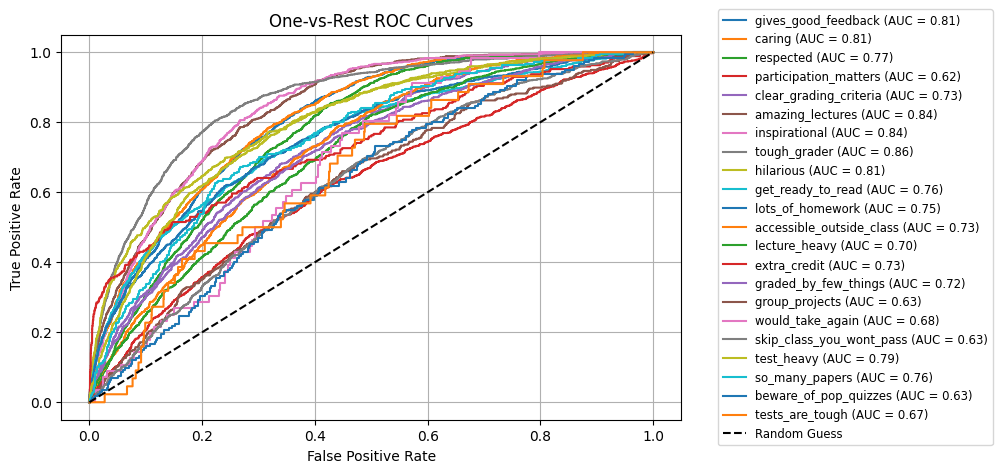

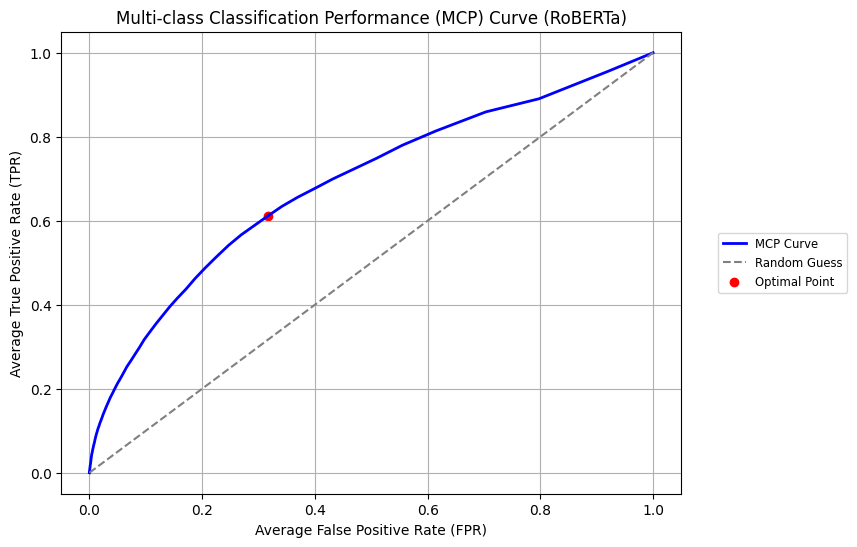

MCP AUC: 0.6870
Optimal Threshold: 0.1212
Optimal Point: FPR = 0.316, TPR = 0.611
Best G-Mean: 0.646


In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
import numpy as np
import torch
import matplotlib.pyplot as plt


def evaluate_metrics(predictions, test_labels, tag_names, threshold=0.1):
    """
    Calculate comprehensive classification metrics for all classes and per class.

    Args:
        predictions: Raw model predictions (logits)
        test_labels: True labels
        tag_names: List of class names
        threshold: Probability threshold for positive prediction
    """
    # Convert logits to probabilities and then to binary predictions
    probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()
    preds = (probabilities > threshold).astype(int)

    # Overall accuracy across all samples and classes
    overall_accuracy = accuracy_score(test_labels.flatten(), preds.flatten())

    # Per-class metrics
    class_metrics = []
    for i in range(len(tag_names)):
        # Per-class accuracy
        class_accuracy = accuracy_score(test_labels[:, i], preds[:, i])

        # True positives, false positives, true negatives, false negatives
        tp = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 1))
        fp = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 1))
        tn = np.sum((test_labels[:, i] == 0) & (preds[:, i] == 0))
        fn = np.sum((test_labels[:, i] == 1) & (preds[:, i] == 0))

        # Calculate precision, recall, f1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Support (number of true instances)
        support = np.sum(test_labels[:, i])

        class_metrics.append({
            'class': tag_names[i],
            'accuracy': class_accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': int(support),
            'true_pos': int(tp),
            'false_pos': int(fp),
            'true_neg': int(tn),
            'false_neg': int(fn)
        })

    # Calculate macro averages
    macro_accuracy = np.mean([m['accuracy'] for m in class_metrics])
    macro_precision = np.mean([m['precision'] for m in class_metrics])
    macro_recall = np.mean([m['recall'] for m in class_metrics])
    macro_f1 = np.mean([m['f1'] for m in class_metrics])

    # Print comprehensive report
    print("\nCLASSIFICATION REPORT")
    print("=" * 100)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Macro Accuracy: {macro_accuracy:.4f}")
    print("\nMacro Averages:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1-Score: {macro_f1:.4f}")

    print("\nPer-Class Metrics:")
    print("-" * 100)
    print(f"{'Class':<30} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 100)

    # Sort classes by F1 score for display
    sorted_metrics = sorted(class_metrics, key=lambda x: x['f1'], reverse=True)

    for metric in sorted_metrics:
        print(f"{metric['class'][:30]:<30} "
              f"{metric['accuracy']:>10.4f} "
              f"{metric['precision']:>10.4f} "
              f"{metric['recall']:>10.4f} "
              f"{metric['f1']:>10.4f} "
              f"{metric['support']:>10d}")

    print("\nDetailed Statistics for Top 5 Classes:")
    print("-" * 100)
    for metric in sorted_metrics[:5]:
        print(f"\nClass: {metric['class']}")
        print(f"True Positives: {metric['true_pos']}")
        print(f"False Positives: {metric['false_pos']}")
        print(f"True Negatives: {metric['true_neg']}")
        print(f"False Negatives: {metric['false_neg']}")

    # Plot ROC curves for one-vs-rest evaluation
    plot_roc_curves(test_labels, probabilities, tag_names)

    # Plot MCP curve
    # plot_mcp_curve(test_labels, probabilities, len(tag_names))
    plot_mcp_curve_with_shared_threshold(test_labels, probabilities, len(tag_names))

    return {
        'overall_accuracy': overall_accuracy,
        'macro_accuracy': macro_accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'class_metrics': class_metrics
    }


def plot_roc_curves(test_labels, probabilities, tag_names):
    """
    Plot one-vs-rest ROC curves for multi-label classification.

    Args:
        test_labels: True binary labels for each class.
        probabilities: Predicted probabilities for each class.
        tag_names: List of class names.
    """
    plt.figure(figsize=(8, 5))

    for i, tag in enumerate(tag_names):
        # Calculate ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(test_labels[:, i], probabilities[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot each class ROC curve
        plt.plot(fpr, tpr, label=f"{tag} (AUC = {roc_auc:.2f})")

    # Plot a diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

    # Add plot details
    plt.title("One-vs-Rest ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize='small')
    # plt.legend(loc="lower right")
    plt.grid()
    plt.show()


def plot_mcp_curve_with_threshold(test_labels, probabilities, num_classes):
    """
    Plot Multi-class Classification Performance (MCP) curve, calculate AUC, and find the optimal point with threshold.

    Args:
        test_labels: True binary labels (one-hot encoded).
        probabilities: Predicted probabilities for each class.
        num_classes: Total number of classes.
    """
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)
    thresholds_list = []  # To collect thresholds for interpolation

    for i in range(num_classes):
        # Calculate FPR, TPR, and thresholds for each class
        fpr, tpr, thresholds = roc_curve(test_labels[:, i], probabilities[:, i])

        # Interpolate TPR and thresholds to align with common FPR points
        interp_tpr = np.interp(all_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        mean_tpr += interp_tpr

        # Interpolate thresholds
        interp_thresholds = np.interp(all_fpr, fpr[::-1], thresholds[::-1])
        thresholds_list.append(interp_thresholds)

    # Average TPR and thresholds across all classes
    mean_tpr /= num_classes
    mean_thresholds = np.mean(thresholds_list, axis=0)

    # Calculate AUC for MCP curve
    mcp_auc = np.trapz(mean_tpr, all_fpr)

    # Find the optimal point (closest to top-left corner)
    distances = np.sqrt(all_fpr**2 + (1 - mean_tpr)**2)  # Euclidean distance to (0, 1)
    optimal_idx = np.argmin(distances)
    optimal_fpr = all_fpr[optimal_idx]
    optimal_tpr = mean_tpr[optimal_idx]
    optimal_threshold = mean_thresholds[optimal_idx]

    # Plot MCP curve
    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, label=f"MCP Curve (AUC = {mcp_auc:.4f})", color='blue', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    plt.scatter(optimal_fpr, optimal_tpr, color='red',
                label=f"Optimal Point ({optimal_fpr:.2f}, {optimal_tpr:.2f}, \nThreshold = {optimal_threshold:.4f})")
    plt.title("Multi-class Classification Performance (MCP) Curve (RoBERTa)")
    plt.xlabel("Average False Positive Rate (FPR)")
    plt.ylabel("Average True Positive Rate (TPR)")
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize='small')
    plt.grid()
    plt.show()

    print(f"MCP AUC: {mcp_auc:.4f}")
    print(f"Optimal Point: FPR = {optimal_fpr:.4f}, TPR = {optimal_tpr:.4f}, Threshold = {optimal_threshold:.4f}")


def evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.1):
    """
    Evaluate model on test set
    """
    # Create test dataset
    dataset = CommentDataset(test_texts, test_labels, tokenizer)
    predictions = trainer.predict(dataset).predictions

    # Calculate and return metrics
    return evaluate_metrics(predictions, test_labels, tag_names, threshold)


# Example usage
metrics = evaluate_on_test_set(trainer, test_texts, test_labels, tokenizer, tag_names, threshold=0.1)


In [15]:
def predict_top3_tags(texts, model, tokenizer, threshold=0.0):
    # Get predictions
    dataset = CommentDataset(texts, np.zeros((len(texts), model.config.num_labels)), tokenizer)
    predictions = trainer.predict(dataset)
    probabilities = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()

    # Initialize arrays with fixed shapes
    n_samples = len(texts)
    n_labels = probabilities.shape[1]
    predictions_binary = np.zeros((n_samples, n_labels))

    # Process each sample
    for i in range(n_samples):
        # Get indices where probability is above threshold
        above_threshold = np.where(probabilities[i] >= threshold)[0]

        # Take up to 3 highest probabilities that meet threshold
        if len(above_threshold) > 0:
            # Sort by probability among those above threshold
            sorted_indices = above_threshold[np.argsort(-probabilities[i][above_threshold])]
            selected_indices = sorted_indices[:3]  # Take up to 3
            predictions_binary[i, selected_indices] = 1

    return predictions_binary, probabilities

In [16]:
def analyze_tag_matches(y_true, y_pred, probabilities, tag_names):
    """
    Analyze different levels of tag matching accuracy
    """
    total_samples = len(y_true)

    # Initialize counters
    stats = {
        'at_least_one_match': 0,
        'at_least_two_matches': 0,
        'exact_three_matches': 0,
        'total_samples': total_samples,
        'match_distribution': {0: 0, 1: 0, 2: 0, 3: 0},
        'true_tag_counts': {0: 0, 1: 0, 2: 0, 3: 0},
        'pred_tag_counts': {0: 0, 1: 0, 2: 0, 3: 0}
    }

    # Detailed examples for each case
    examples = {
        'two_matches': [],
        'three_matches': [],
        'no_matches': []
    }

    for i in range(total_samples):
        true_indices = set(np.where(y_true[i] == 1)[0])
        pred_indices = set(np.where(y_pred[i] == 1)[0])

        # Count number of true and predicted tags
        num_true = len(true_indices)
        num_pred = len(pred_indices)
        stats['true_tag_counts'][min(3, num_true)] += 1
        stats['pred_tag_counts'][min(3, num_pred)] += 1

        # Calculate intersection
        intersection = true_indices.intersection(pred_indices)
        num_matches = len(intersection)

        # Update match distribution
        stats['match_distribution'][num_matches] += 1

        # Update match counters
        if num_matches >= 1:
            stats['at_least_one_match'] += 1
        if num_matches >= 2:
            stats['at_least_two_matches'] += 1
            if len(examples['two_matches']) < 3:  # Store up to 3 examples
                examples['two_matches'].append({
                    'text': test_texts[i],
                    'true_tags': [tag_names[j] for j in true_indices],
                    'pred_tags': [(tag_names[j], probabilities[i][j]) for j in pred_indices],
                    'matches': [tag_names[j] for j in intersection]
                })
        if num_matches == 3:
            stats['exact_three_matches'] += 1
            if len(examples['three_matches']) < 3:
                examples['three_matches'].append({
                    'text': test_texts[i],
                    'true_tags': [tag_names[j] for j in true_indices],
                    'pred_tags': [(tag_names[j], probabilities[i][j]) for j in pred_indices],
                    'matches': [tag_names[j] for j in intersection]
                })
        if num_matches == 0 and len(examples['no_matches']) < 3:
            examples['no_matches'].append({
                'text': test_texts[i],
                'true_tags': [tag_names[j] for j in true_indices],
                'pred_tags': [(tag_names[j], probabilities[i][j]) for j in pred_indices]
            })

    # Print comprehensive report
    print("\nTAG MATCHING ANALYSIS")
    print("=" * 80)

    print("\n1. Overall Matching Statistics:")
    print(f"Total samples: {total_samples}")
    print(f"At least one matching tag: {stats['at_least_one_match']} ({stats['at_least_one_match']/total_samples*100:.1f}%)")
    print(f"At least two matching tags: {stats['at_least_two_matches']} ({stats['at_least_two_matches']/total_samples*100:.1f}%)")
    print(f"Exact three matching tags: {stats['exact_three_matches']} ({stats['exact_three_matches']/total_samples*100:.1f}%)")

    print("\n2. Match Distribution:")
    print(f"{'Matches':<15} {'Count':>10} {'Percentage':>12}")
    print("-" * 40)
    for matches, count in stats['match_distribution'].items():
        print(f"{f'{matches} tags':<15} {count:>10} {count/total_samples*100:>11.1f}%")

    print("\n3. True Tags Distribution:")
    print(f"{'True Tags':<15} {'Count':>10} {'Percentage':>12}")
    print("-" * 40)
    for tags, count in stats['true_tag_counts'].items():
        print(f"{f'{tags} tags':<15} {count:>10} {count/total_samples*100:>11.1f}%")

    print("\n4. Predicted Tags Distribution:")
    print(f"{'Pred Tags':<15} {'Count':>10} {'Percentage':>12}")
    print("-" * 40)
    for tags, count in stats['pred_tag_counts'].items():
        print(f"{f'{tags} tags':<15} {count:>10} {count/total_samples*100:>11.1f}%")

    print("\n5. Example Cases:")

    if examples['three_matches']:
        print("\nPerfect Match Examples (3 matches):")
        for ex in examples['three_matches'][:2]:
            print("\nText:", ex['text'][:100], "...")
            print("True tags:", ", ".join(ex['true_tags']))
            print("Predicted tags:")
            for tag, prob in ex['pred_tags']:
                print(f"- {tag} (confidence: {prob:.2f})")

    if examples['two_matches']:
        print("\nPartial Match Examples (2 matches):")
        for ex in examples['two_matches'][:2]:
            print("\nText:", ex['text'][:100], "...")
            print("True tags:", ", ".join(ex['true_tags']))
            print("Predicted tags:")
            for tag, prob in ex['pred_tags']:
                print(f"- {tag} (confidence: {prob:.2f})")
            print("Matching tags:", ", ".join(ex['matches']))

    if examples['no_matches']:
        print("\nNo Match Examples:")
        for ex in examples['no_matches'][:2]:
            print("\nText:", ex['text'][:100], "...")
            print("True tags:", ", ".join(ex['true_tags']))
            print("Predicted tags:")
            for tag, prob in ex['pred_tags']:
                print(f"- {tag} (confidence: {prob:.2f})")

    return stats

# Run the analysis
print("\nEvaluating tag matching...")
predictions_binary, probabilities = predict_top3_tags(test_texts, model, tokenizer, threshold=0.09)
matching_stats = analyze_tag_matches(test_labels, predictions_binary, probabilities, tag_names)


Evaluating tag matching...



TAG MATCHING ANALYSIS

1. Overall Matching Statistics:
Total samples: 7010
At least one matching tag: 5519 (78.7%)
At least two matching tags: 2173 (31.0%)
Exact three matching tags: 203 (2.9%)

2. Match Distribution:
Matches              Count   Percentage
----------------------------------------
0 tags                1491        21.3%
1 tags                3346        47.7%
2 tags                1970        28.1%
3 tags                 203         2.9%

3. True Tags Distribution:
True Tags            Count   Percentage
----------------------------------------
0 tags                 134         1.9%
1 tags                 631         9.0%
2 tags                1160        16.5%
3 tags                5085        72.5%

4. Predicted Tags Distribution:
Pred Tags            Count   Percentage
----------------------------------------
0 tags                   0         0.0%
1 tags                   0         0.0%
2 tags                   0         0.0%
3 tags                7010       100.

In [17]:
predictions_binary, probabilities = predict_top3_tags(test_texts, model, tokenizer, threshold=0.12)
matching_stats = analyze_tag_matches(test_labels, predictions_binary, probabilities, tag_names)


TAG MATCHING ANALYSIS

1. Overall Matching Statistics:
Total samples: 7010
At least one matching tag: 5519 (78.7%)
At least two matching tags: 2173 (31.0%)
Exact three matching tags: 203 (2.9%)

2. Match Distribution:
Matches              Count   Percentage
----------------------------------------
0 tags                1491        21.3%
1 tags                3346        47.7%
2 tags                1970        28.1%
3 tags                 203         2.9%

3. True Tags Distribution:
True Tags            Count   Percentage
----------------------------------------
0 tags                 134         1.9%
1 tags                 631         9.0%
2 tags                1160        16.5%
3 tags                5085        72.5%

4. Predicted Tags Distribution:
Pred Tags            Count   Percentage
----------------------------------------
0 tags                   0         0.0%
1 tags                   0         0.0%
2 tags                   0         0.0%
3 tags                7010       100.

In [18]:
import torch
import numpy as np

def predict_tags_for_sentence(sentence, model, tokenizer, tag_names, threshold=0.1, device='cuda'):
    """
    Predict tags for a single sentence.

    Args:
    - sentence (str): Input sentence to predict tags for.
    - model: Trained model for predictions.
    - tokenizer: Tokenizer used for preprocessing.
    - tag_names (list): List of tag names.
    - threshold (float): Confidence threshold for tag prediction.
    - device (str): Device to use ('cuda' or 'cpu').

    Returns:
    - predicted_tags (list): List of predicted tags with confidence scores.
    """
    # Move model to the specified device
    model = model.to(device)

    # Tokenize and preprocess the input sentence
    inputs = tokenizer([sentence], return_tensors="pt", truncation=True, padding=True)

    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = outputs.logits.sigmoid().cpu().numpy()[0]  # Move logits back to CPU

    # Apply threshold to determine predicted tags
    predicted_indices = np.where(probabilities >= threshold)[0]
    predicted_tags = [(tag_names[i], probabilities[i]) for i in predicted_indices]

    # Sort tags by confidence
    predicted_tags = sorted(predicted_tags, key=lambda x: x[1], reverse=True)

    return predicted_tags

# Example usage
sentence = (
'the professor wa veri clear from day 1 about the cours expect and provid a blueprint of how to navig through the cours the best part of cours is that the professor wa veri activ on piazza provid constant support and guidanc the assign were heavi but will realli elev our skill and profil to set us up for futur'
)

# Ensure model and tokenizer are properly initialized and loaded
# Example: model = YourModelClass.load_from_checkpoint('your_model_path')
# tokenizer = YourTokenizer.from_pretrained('your_tokenizer_name')

# Predict tags for the sentence
predicted_tags = predict_tags_for_sentence(sentence, model, tokenizer, tag_names, threshold=0.1, device='cuda')

# Print the predicted tags
print("\nPredicted Tags:")
for tag, confidence in predicted_tags:
    print(f"- {tag} (confidence: {confidence:.2f})")



Predicted Tags:
- caring (confidence: 0.48)
- gives_good_feedback (confidence: 0.45)
- accessible_outside_class (confidence: 0.32)
- respected (confidence: 0.29)
- participation_matters (confidence: 0.19)
- clear_grading_criteria (confidence: 0.18)
- amazing_lectures (confidence: 0.16)
- lots_of_homework (confidence: 0.14)
- inspirational (confidence: 0.13)
- get_ready_to_read (confidence: 0.10)


In [ ]:
#### regression

In [ ]:

import torch
from torch import nn
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the RoBERTa regression model
class RobertaRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.1)
        self.regressor = nn.Linear(768, 2)  # 2 outputs for rating and difficulty

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        return self.regressor(pooled_output)

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaRegressor().to(device)

# Create datasets
train_dataset = CommentDataset(
    train_texts,
    train_df[['star_rating', 'course_difficulty']].values,  # Only rating and difficulty
    tokenizer
)

test_dataset = CommentDataset(
    test_texts,
    test_df[['star_rating', 'course_difficulty']].values,  # Only rating and difficulty
    tokenizer
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()
num_epochs = 1

# Training loop
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    mse_rating = np.mean((all_preds[:, 0] - all_labels[:, 0]) ** 2)
    mse_difficulty = np.mean((all_preds[:, 1] - all_labels[:, 1]) ** 2)

    return {
        'avg_loss': total_loss / len(dataloader),
        'mse_rating': mse_rating,
        'mse_difficulty': mse_difficulty
    }

# Training loop
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    print(f"Training loss: {train_loss:.4f}")

    # Evaluate
    eval_metrics = evaluate(model, test_loader, criterion)
    print(f"Validation loss: {eval_metrics['avg_loss']:.4f}")
    print(f"Rating MSE: {eval_metrics['mse_rating']:.4f}")
    print(f"Difficulty MSE: {eval_metrics['mse_difficulty']:.4f}")

    # Save best model
    if eval_metrics['avg_loss'] < best_loss:
        best_loss = eval_metrics['avg_loss']
        torch.save(model.state_dict(), 'best_roberta_regressor.pt')

# Load best model and evaluate
model.load_state_dict(torch.load('best_roberta_regressor.pt'))
final_metrics = evaluate(model, test_loader, criterion)
print("\nFinal Results:")
print(f"Rating MSE: {final_metrics['mse_rating']:.4f}")
print(f"Difficulty MSE: {final_metrics['mse_difficulty']:.4f}")

Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


100%|██████████| 1753/1753 [10:32<00:00,  2.77it/s]


Training loss: 0.9462
Validation loss: 0.6757
Rating MSE: 0.5106
Difficulty MSE: 0.8420

Epoch 2/5


100%|██████████| 1753/1753 [10:29<00:00,  2.78it/s]


Training loss: 0.6723
Validation loss: 0.6758
Rating MSE: 0.5087
Difficulty MSE: 0.8440

Epoch 3/5


 12%|█▏        | 203/1753 [01:12<09:17,  2.78it/s]

In [ ]:
def predict_scores(model, tokenizer, text, device):
    # Ensure model is in evaluation mode
    model.eval()

    # Preprocess the text
    encoding = tokenizer(
        str(text),
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    # Move inputs to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        predictions = outputs.cpu().numpy()[0]  # Convert to numpy array

    # Return rating and difficulty predictions
    rating = round(float(predictions[0]), 1)
    difficulty = round(float(predictions[1]), 1)

    return {
        'rating': rating,
        'difficulty': difficulty
    }

# Example usage:
# First load your trained model
model.load_state_dict(torch.load('best_roberta_regressor.pt'))
model = model.to(device)

# Make a prediction
test_comment = "i have not even finish the cours yet but just a word of warn even if you do your work 100 correctli you will be mark down hi grader can make multipl mistak while grade your assign and he onli allow you to appeal one grade thi mean even if you do your work correctli and they make a mistak you will be penal for it"
results = predict_scores(model, tokenizer, test_comment, device)

print(f"Predicted Rating: {results['rating']}")
print(f"Predicted Difficulty: {results['difficulty']}")

In [ ]:
#### orignial

In [ ]:
# Prepare labels
labels = df[['student_difficult', 'student_star', 'gives_good_feedback', 'caring', 'respected']].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['comments'], labels, test_size=0.2, random_state=42)

# Create datasets
train_dataset = CustomDataset(X_train.tolist(), y_train.tolist())
test_dataset = CustomDataset(X_test.tolist(), y_test.tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Define the model (5 outputs: 2 for regression, 3 for classification)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Custom loss function
def custom_loss(outputs, labels):
    mse_loss = torch.nn.MSELoss()
    bce_loss = torch.nn.BCEWithLogitsLoss()

    # MSE for difficulty and rating (first two outputs)
    reg_loss = mse_loss(outputs[:, :2], labels[:, :2])

    # BCE for the three tags (last three outputs)
    class_loss = bce_loss(outputs[:, 2:], labels[:, 2:])

    # Combine losses (you can adjust the weights if needed)
    total_loss = reg_loss + class_loss
    return total_loss

# Custom Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = custom_loss(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Create Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,3.224300
1000,1.682000


TrainOutput(global_step=1140, training_loss=2.331558455082408, metrics={'train_runtime': 1356.598, 'train_samples_per_second': 6.714, 'train_steps_per_second': 0.84, 'total_flos': 2396480041562112.0, 'train_loss': 2.331558455082408, 'epoch': 3.0})

In [ ]:
# Save the model
output_dir = '/content/finetuned_model'
model.save_pretrained(output_dir)
# trainer.tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")


Model saved to /content/finetuned_model


In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Make predictions
predictions = trainer.predict(test_dataset)
predicted_values = predictions.predictions

# Separate predictions
predicted_difficulty = predicted_values[:, 0]
predicted_rating = predicted_values[:, 1]
predicted_tags = (predicted_values[:, 2:] > 0.5).astype(int)

# Calculate MSE for difficulty and rating
difficulty_mse = mean_squared_error(y_test[:, 0], predicted_difficulty)
rating_mse = mean_squared_error(y_test[:, 1], predicted_rating)
print(f"Difficulty Mean Squared Error: {difficulty_mse}")
print(f"Rating Mean Squared Error: {rating_mse}")

Evaluation results: {'eval_loss': 1.6852487325668335, 'eval_runtime': 24.9748, 'eval_samples_per_second': 30.431, 'eval_steps_per_second': 3.804, 'epoch': 3.0}
Difficulty Mean Squared Error: 1.2935267965562556
Rating Mean Squared Error: 0.8844834371420222


In [ ]:
# Calculate accuracy and print classification report for tags
tags = ['gives_good_feedback', 'caring', 'respected']
for i, tag in enumerate(tags):
    accuracy = accuracy_score(y_test[:, i+2], predicted_tags[:, i])
    print(f"\n{tag} Accuracy: {accuracy}")
    print(classification_report(y_test[:, i+2], predicted_tags[:, i]))


gives_good_feedback Accuracy: 0.7105263157894737
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83       540
         1.0       0.00      0.00      0.00       220

    accuracy                           0.71       760
   macro avg       0.36      0.50      0.42       760
weighted avg       0.50      0.71      0.59       760


caring Accuracy: 0.7157894736842105
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.83       544
         1.0       0.00      0.00      0.00       216

    accuracy                           0.72       760
   macro avg       0.36      0.50      0.42       760
weighted avg       0.51      0.72      0.60       760


respected Accuracy: 0.6986842105263158
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82       531
         1.0       0.00      0.00      0.00       229

    accuracy                           0.70       760
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m